In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchtext

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [3]:
!rm ./wiki-news-300d-1M -r
!rm ./GoogleNews-vectors-negative300 -r
!rm ./paragram_300_sl999 -r

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
test_csv  = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_csv = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

In [6]:
train_csv.info(), test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


(None, None)

In [7]:
train_csv.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [8]:
test_csv.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


# Exploratory Data Analysis

## Tokenize sentences and look at their lengths

In [9]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [10]:
# Tokenize sentences in train and test sets
train_csv_tokenized = train_csv.copy()
test_csv_tokenized  = test_csv.copy()
train_csv_tokenized['question_text'] = train_csv['question_text'].apply(lambda x: tokenizer(x))
test_csv_tokenized['question_text']  = test_csv['question_text'].apply(lambda x: tokenizer(x))

In [11]:
# Get train and test sentence word counts
train_lens = train_csv_tokenized['question_text'].str.len()
test_lens  = test_csv_tokenized['question_text'].str.len()

(array([2.3000e+01, 1.9414e+04, 8.2210e+04, 9.4476e+04, 6.2192e+04,
        3.8077e+04, 2.4214e+04, 1.6343e+04, 1.1583e+04, 5.7650e+03,
        6.4340e+03, 4.3170e+03, 2.9310e+03, 2.1580e+03, 1.8710e+03,
        1.4730e+03, 1.0740e+03, 6.1500e+02, 3.6000e+02, 1.1600e+02,
        1.1000e+02, 3.4000e+01, 9.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ,
        32.9, 35.8, 38.7, 41.6, 44.5, 47.4, 50.3, 53.2, 56.1, 59. , 61.9,
        64.8, 67.7, 70.6, 73.5, 76.4, 79.3, 82.2, 85.1, 88. ]),
 <BarContainer object of 30 artists>)

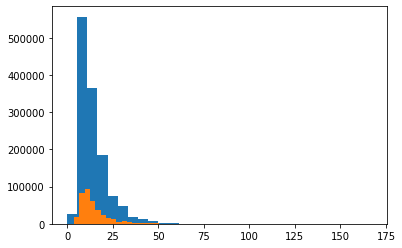

In [12]:
# Plot sentence word counts
plt.hist(train_lens, bins=30)
plt.hist(test_lens, bins=30)

Most sentences have less than 50 words, so lets choose 50 as max_len

In [13]:
from collections import Counter

vocab = Counter()
for sentence in train_csv_tokenized['question_text'].values:
    vocab.update(sentence)

In [14]:
glove_path = './glove.840B.300d/glove.840B.300d.txt'
glove = torchtext.vocab.Vectors(glove_path)

100%|█████████▉| 2196016/2196017 [03:33<00:00, 10285.88it/s]


In [15]:
def check_coverage(vocab, embedding):
    found = Counter()
    oov = Counter()
    for word in tqdm(vocab):
        if any(embedding[word] != 0.):
            found.update({word: vocab[word]})
        else:
            oov.update({word: vocab[word]})
            
    print("Percentage of unique words not found in GloVe: ", len(oov) / len(vocab) * 100, "%")
    print("Percentage of words not found in GloVe in total: ", sum(oov.values()) / sum(vocab.values()) * 100, "%")

    return found, oov

In [16]:
found, oov = check_coverage(vocab, glove)

100%|██████████| 260188/260188 [01:17<00:00, 3354.09it/s]

Percentage of unique words not found in GloVe:  47.389964179746954 %
Percentage of words not found in GloVe in total:  1.129196160941184 %


In [17]:
oov.most_common(100)

[('i’m', 2573),
 ('don’t', 2244),
 ('what’s', 1817),
 ('it’s', 1077),
 ('can’t', 1039),
 ('quorans', 855),
 ('doesn’t', 814),
 ('100%', 661),
 ('i’ve', 582),
 ('isn’t', 540),
 ('didn’t', 503),
 ('cryptocurrencies', 497),
 ('brexit', 495),
 ('you’ve', 495),
 ('redmi', 382),
 ('you’re', 359),
 ('paytm', 351),
 ('kvpy', 350),
 ('iiser', 336),
 ('ethereum', 329),
 ('50%', 321),
 ('[/math]', 294),
 ('aren’t', 293),
 ('[math]', 285),
 ('90%', 276),
 ('iisc', 268),
 ('won’t', 266),
 ('he’s', 261),
 ('$1', 259),
 ('$100', 256),
 ('c#', 252),
 ('they’re', 243),
 ('trump’s', 239),
 ('//www', 230),
 ('5%', 229),
 ('60%', 219),
 ('10%', 216),
 ('jinping', 211),
 ('viteee', 185),
 ('that’s', 185),
 ('haven’t', 177),
 ('iocl', 176),
 ('$10', 174),
 ('80%', 173),
 ('1%', 171),
 ('20%', 170),
 ('wouldn’t', 170),
 ('nmims', 163),
 ('75%', 161),
 ('95%', 158),
 ('fortnite', 156),
 ('rohingya', 156),
 ('upes', 156),
 ('shouldn’t', 154),
 ('coinbase', 148),
 ('85%', 146),
 ('cpec', 145),
 ('she’s', 145),


Most oov-s come from words that include ', ", $, -, and % symbols.

TODO: Split, remove or replace these symbols.

In [18]:
def clean_and_tokenize(x):
    global tokenizer
        
    # Replace , " ’ ” ‘ [ ] { } … ™ ` ´
    x = x.replace(',', '').replace('“', '').replace('’', "'").replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace('…', '')\
        .replace('”', '"').replace('‘', '').replace('™', ' tm ').replace('`', "'").replace('´', "'")
    # Add extra space to %, $, ^, #
    x = x.replace('%', ' % ').replace('$', ' $ ').replace('^', ' ^ ').replace('#', ' # ').replace('/', ' / ').replace('+', ' + ').replace('&', ' & ')\
        .replace('-', ' - ').replace('|', ' | ').replace('=', ' = ').replace('>', ' > ').replace('<', ' < ').replace('\\', ' \ ').replace('*', ' * ')\
        .replace('₹', ' ₹ ').replace('£', ' £ ')
    
    return tokenizer(x)

In [19]:
# Tokenize sentences in train and test sets
train_csv_tokenized = train_csv
test_csv_tokenized  = test_csv
train_csv_tokenized['question_text'] = train_csv['question_text'].apply(lambda x: clean_and_tokenize(x))
test_csv_tokenized['question_text']  = test_csv['question_text'].apply(lambda x: clean_and_tokenize(x))

In [20]:
from collections import Counter

vocab = Counter()
for sentence in tqdm(train_csv_tokenized['question_text'].values):
    vocab.update(sentence)

100%|██████████| 1306122/1306122 [00:05<00:00, 220031.57it/s]


In [21]:
found, oov = check_coverage(vocab, glove)

100%|██████████| 199679/199679 [01:04<00:00, 3091.89it/s]


Percentage of unique words not found in GloVe:  37.497683782470865 %
Percentage of words not found in GloVe in total:  0.6474193021414578 %


In [22]:
oov.most_common(100)

[('quorans', 858),
 ('brexit', 524),
 ('cryptocurrencies', 499),
 ('redmi', 383),
 ('kvpy', 356),
 ('paytm', 355),
 ('iiser', 345),
 ('ethereum', 334),
 ('iisc', 278),
 ('₹', 227),
 ('jinping', 211),
 ('viteee', 186),
 ('iocl', 178),
 ('nmims', 163),
 ('rohingya', 157),
 ('upes', 157),
 ('fortnite', 156),
 ('coinbase', 149),
 ('nsit', 147),
 ('cpec', 146),
 ('iitians', 143),
 ('oneplus', 139),
 ('jadavpur', 138),
 ('udemy', 128),
 ('lyft', 126),
 ('bahubali', 123),
 ('uceed', 123),
 ('afcat', 123),
 ('coep', 119),
 ('bhakts', 115),
 ('demonetisation', 115),
 ('upwork', 111),
 ('machedo', 108),
 ('gdpr', 107),
 ('nlu', 107),
 ('adityanath', 106),
 ('upsee', 105),
 ('boruto', 102),
 ('bnbr', 100),
 ('chsl', 99),
 ('kernan', 97),
 ('amcat', 94),
 ('udacity', 93),
 ('josaa', 93),
 ('kylo', 93),
 ('alshamsi', 92),
 ('vishwanathan', 92),
 ('iitian', 91),
 ('dceu', 90),
 ('litecoin', 87),
 ('unacademy', 86),
 ('iiest', 86),
 ('laravel', 84),
 ('sjws', 84),
 ('rvce', 84),
 ('qoura', 82),
 ('vj

# Model building

In [23]:
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(train_csv_tokenized['question_text'], specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

# TODO: plot word frequencies and keep words that appear at least x amount of times, DO THIS IN ABOVE CELLS WITH COUNTER

In [24]:
vocab.get_itos()[:20]

['<unk>',
 '?',
 'the',
 'what',
 'is',
 'a',
 'to',
 'in',
 'of',
 'i',
 'how',
 'and',
 'do',
 'are',
 'for',
 'you',
 'can',
 "'",
 'why',
 'it']

(array([6.6156e+04, 1.9096e+05, 6.9765e+04, 2.7812e+04, 1.2556e+04,
        4.8990e+03, 2.7010e+03, 7.9100e+02, 1.3700e+02, 1.5000e+01,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.  ,   8.24,  15.48,  22.72,  29.96,  37.2 ,  44.44,  51.68,
         58.92,  66.16,  73.4 ,  80.64,  87.88,  95.12, 102.36, 109.6 ,
        116.84, 124.08, 131.32, 138.56, 145.8 , 153.04, 160.28, 167.52,
        174.76, 182.  , 189.24, 196.48, 203.72, 210.96, 218.2 , 225.44,
        232.68, 239.92, 247.16

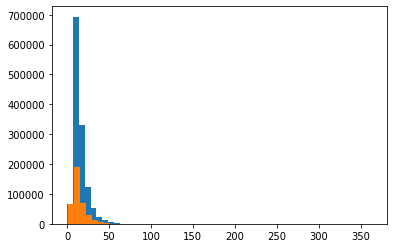

In [25]:
plt.hist(train_csv_tokenized['question_text'].str.len(), bins=50)
plt.hist(test_csv_tokenized['question_text'].str.len(), bins=50)

In [26]:
SEED = 78
VAL_SPLIT = 0.9
MAX_SEQ_LEN = 60

# Shuffle, truncate and divide into train and validation sets
train_size = int(len(train_csv_tokenized) * VAL_SPLIT)
train_val = train_csv_tokenized.sample(frac=1, random_state=SEED)
train_set = train_val[:train_size]
val_set   = train_val[train_size:]

In [27]:
from torch.utils.data import DataLoader, TensorDataset

def truncate(txt: list):
    return txt[:min(MAX_SEQ_LEN, len(txt))]

def collate_batch(batch):
    x_s, y_s = [], []

    for text, label in batch:
        y_s.append(label)
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = vocab(truncate(text))
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        x_s.append(x)

    y_s = torch.tensor(y_s, dtype=torch.int32)
    x_s = torch.stack(x_s, dim=0)
    return x_s, y_s

train_dl = DataLoader(
    list(zip(train_set['question_text'], train_set['target'])), 
    batch_size=1024, 
    shuffle=True, 
    collate_fn=collate_batch)

valid_dl = DataLoader(
    list(zip(val_set['question_text'], val_set['target'])), 
    batch_size=1024*2, 
    shuffle=False, 
    collate_fn=collate_batch)

In [28]:
embed_vecs = glove.get_vecs_by_tokens(vocab.get_itos())

In [29]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        global vocab
        self.embedding_dim = 300
        self.hidden_dim = 50
        
        # Embedding layer with learning turned off
        self.emb = nn.Embedding(
            num_embeddings = len(vocab), 
            embedding_dim = self.embedding_dim,
            padding_idx = 0,
            sparse = False
        )
        self.emb.weight = nn.Parameter(embed_vecs)
        self.emb.weight.requires_grad = False
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_dim, 
            bias = True,
            batch_first = True,
            bidirectional = True
        )
        
        
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(
            in_features  = self.hidden_dim * MAX_SEQ_LEN * 2, 
            out_features = 1, 
            bias = True
        )

    def forward(self, inp):
        emb_output = self.emb(inp)
        #print('Embedding: ', emb_output.shape)
        
        h0 = torch.zeros(2, inp.size(0), self.hidden_dim, device=inp.device)
        c0 = torch.zeros(2, inp.size(0), self.hidden_dim, device=inp.device)
        #print('Lstm args: ', h0.shape, c0.shape)
        
        lstm_output, _ = self.lstm(emb_output, (h0, c0))
        #print('LSTM: ', lstm_output.shape)
        
        # Flatten the vectors
        lstm_output = self.flatten(lstm_output)
        #print('LSTM flat:', lstm_output.shape)
        
        last = self.lin(lstm_output)
        #print('Final: ', last.shape)
        
        return last

In [30]:
ClassifierModel()

ClassifierModel(
  (emb): Embedding(199680, 300, padding_idx=0)
  (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=6000, out_features=1, bias=True)
)

In [31]:
THRESHOLD = 0.5
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calc_accuracy(y, y_pred):
    #return torch.Tensor((sigmoid(y_pred.detach().numpy()) > THRESHOLD))
    return (torch.sum(y == torch.Tensor((sigmoid(y_pred.detach().numpy()) > THRESHOLD))).item() / y.size(0) * 100)

In [32]:
def train_loop(model, epochs: int = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    print("Training started.")
    
    for epoch in range(epochs):
        start_time = time.time()
        for i, (x, y) in enumerate(train_dl):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
        for x_train, y_train in train_dl:
            train_pred = model(x_train)
            train_loss += loss_fn(train_pred, y_train.unsqueeze(1).float()).item()
            train_acc += calc_accuracy(y_train, train_pred)

        for x_val, y_val in valid_dl:
            val_pred = model(x_val)
            val_loss += loss_fn(val_pred, y_val.unsqueeze(1).float()).item()
            val_acc += calc_accuracy(y_val, val_pred)

        elapsed_time = time.time() - start_time

        print('Epoch: ', epoch + 1, 
              #'\tIter: ', i + 1, 
              '\tLoss: {:.9f}'.format(train_loss / len(train_dl)),
              '\tAccuracy: {:.3f}%'.format(train_acc / len(train_dl)),
              '\tVal Loss: {:.9f}'.format(val_loss / len(valid_dl)),
              '\tVal Accuracy: {:.3f}%'.format(val_acc / len(valid_dl)),
              '\tTime: {:.3f}s', elapsed_time)
    
    print('Training ended.')

In [33]:
model = ClassifierModel()
train_loop(model, epochs=5)

Training started.
Epoch:  1 	Loss: 0.105945954 	Accuracy: 91242.052% 	Val Loss: 0.106005981 	Val Accuracy: 181934.169% 	Time: {:.3f}s 1381.2586572170258
Epoch:  2 	Loss: 0.098877075 	Accuracy: 91328.854% 	Val Loss: 0.100753544 	Val Accuracy: 182166.159% 	Time: {:.3f}s 1375.469530582428
Epoch:  3 	Loss: 0.095350282 	Accuracy: 91317.913% 	Val Loss: 0.099473024 	Val Accuracy: 182082.693% 	Time: {:.3f}s 1404.9409523010254
Epoch:  4 	Loss: 0.092904191 	Accuracy: 92061.649% 	Val Loss: 0.099201881 	Val Accuracy: 183575.670% 	Time: {:.3f}s 1456.6047897338867
Epoch:  5 	Loss: 0.091136023 	Accuracy: 90839.322% 	Val Loss: 0.099106745 	Val Accuracy: 181077.551% 	Time: {:.3f}s 1449.7591795921326
Training ended.


In [34]:
def collate_batch_test(batch):
    qids, x_s = [], []

    for qid, text, in batch:
        qids.append(qid)
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = vocab(truncate(text))
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        x_s.append(x)
    
    x_s = torch.stack(x_s, dim=0)
    return qids, x_s

test_dl = DataLoader(
    list(zip(test_csv_tokenized['qid'], test_csv_tokenized['question_text'])), 
    batch_size=1024*2, 
    shuffle=False, 
    collate_fn=collate_batch_test)

In [35]:
ans = pd.DataFrame(columns=['qid', 'prediction'])
for qid, x in test_dl:
    tmp = pd.DataFrame(columns=['qid', 'prediction'])
    tmp['qid'] = qid
    tmp['prediction'] = (sigmoid(model(x).detach().numpy()) > THRESHOLD).astype(int)
    ans = ans.append(tmp)

In [36]:
ans

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
1017,ffff7fa746bd6d6197a9,0
1018,ffffa1be31c43046ab6b,0
1019,ffffae173b6ca6bfa563,0
1020,ffffb1f7f1a008620287,0


In [37]:
ans.to_csv('submission.csv', index=False)

In [38]:
x = torch.LongTensor([[1]*60, [2]*60])
y = torch.Tensor([1, 0])

In [39]:
calc_accuracy(y, model(x))

100.0